In [1]:
import numpy as np
import gymnasium as gym
import torch

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
# The "ipympl" backend is better, as it allows for interactiveness, but on some installations it does not work, then use "inline"
%matplotlib ipympl
# %matplotlib inline  

# this way of importing allow to reload/refresh the module later with importlib.reload(policy)
import policy as policy 
import memory as mem
from feedforward import Feedforward

Load environment, policy and memory.

In [2]:
env = gym.make('Pendulum-v1', g=9.81, render_mode="human")
pi = policy.PDPolicy(env)
buffer = mem.Memory() # buffer 

## Inspect the environment 

In [3]:
s , _ = env.reset()
for t in range(100):
    a = pi.get_action(s) 
    s_new, rew, term, trunc, _ = env.step(a)
    buffer.add_transition([s,a,rew,s_new, term, trunc])
    s = s_new

In [4]:
transitions = buffer.get_all_transitions()
states = np.vstack(transitions[:,0])
actions = transitions[:,1]
rewards = transitions[:,2]

Plot the trajectory: (state, action, reward)
 
 The state is [position, velocity] 
 
 **changes are needed**

Text(0, 0.5, 'rewards')

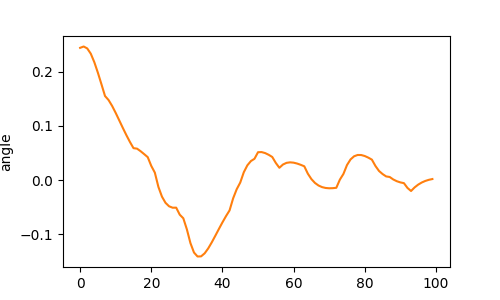

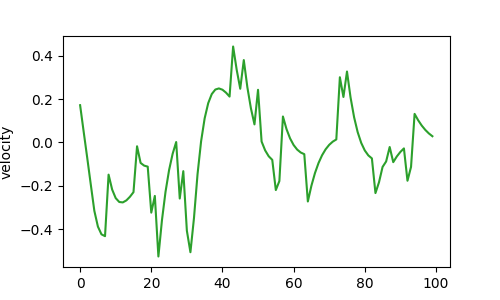

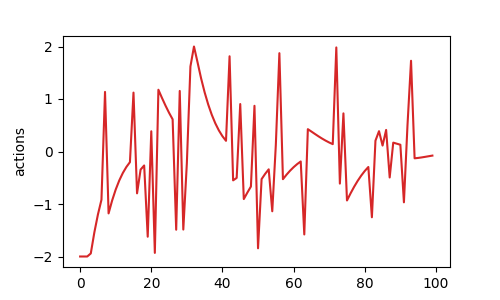

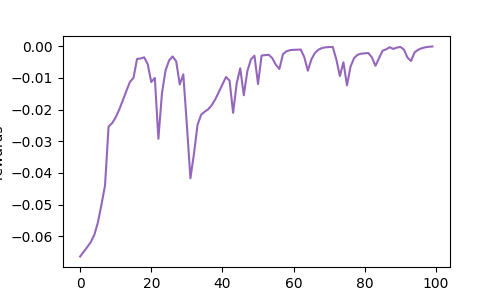

In [5]:
angle = np.arctan(states[:, 1]/ states[:, 0])

plt.figure(figsize=(5,3))
plt.plot(angle, color='tab:orange')
plt.ylabel('angle')

plt.figure(figsize=(5,3))
plt.plot(states[:, 2], color='tab:green')
plt.ylabel('velocity')

plt.figure(figsize=(5,3))
plt.plot(actions, color='tab:red')
plt.ylabel('actions')

plt.figure(figsize=(5,3))
plt.plot(rewards, color='tab:purple')
plt.ylabel('rewards')

# Collect data

We do 500 rollouts a 100 timesteps with the black box policy. Nothing needs to be changed here.

In [6]:
env = gym.make('Pendulum-v1', g=9.81, render_mode=None) # switch off rendering
for ep in range(500):
    # start a larger range initial conditions to see enough of the statespace
    s, _ = env.reset(options={"y_init": 4.0})
    for t in range(100):
        a = pi.get_action(s) 
        s_new, rew, term, trunc, _ = env.step(a)
        buffer.add_transition([s,a,rew,s_new, term, trunc])
        s = s_new

In [7]:
buffer.size

50100

# Fit value function

The value function fitting class. Here, you need to fill in the blank parts

In [8]:
class ValueFunction(Feedforward):
    def __init__(self, observation_dim, hidden_sizes=[100,100]):
        super().__init__(input_size=observation_dim, hidden_sizes=hidden_sizes, output_size=1)
        
        # so this class is already a neural network, see feedforward.py        
        # add and optimizer here (e.g. Adam with lr = 0.0002, eps=0.000001)
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0002, eps = 0.000001)
        
        # add a loss function here
        self.loss = torch.nn.MSELoss()
    
    def fit(self, observations, targets):
        # Add one training step here. 
        # The states are called here observations        
        self.optimizer.zero_grad()
        
        # Hints:         
        # convert the inputs into torch tensors with torch.from_numpy
        # use self.forward(input) to make a prediction to be used in the loss
        inputs = torch.from_numpy(np.stack(observations).astype(np.float32))
        output = self.forward(inputs)
        
        # calculate loss and back-prop
        loss = self.loss(output, targets)
        loss.backward()
        self.optimizer.step()
        
        # return the current loss
        return loss.item()

In [9]:
valuefunc = ValueFunction(observation_dim=env.observation_space.shape[0])

Fitting routine of the value function. Fill in the blank parts.

In [10]:
def fit_value(iter_fit=100, gamma=0.95):
    
    plt_fit = []
    for i in range(iter_fit):
    
        # sample from the replay buffer
        data=buffer.sample(batch=512)
        # each entry in data is (state,action,reward,next_state, term, trunc)    
        
        # Hints:
        #  use can use np.stack to convert the array or arrays into one array
        #  it is really important that you check the shapes of your arrays.
        #  It should be (128,2) for the state and (128,1) for reward and values
        
        state = data[:,0]
        
        td_target = (torch.from_numpy(np.stack(data[:,2])[:, None].astype(np.float32)) 
                     + gamma*valuefunc.forward(torch.from_numpy(np.stack(data[:,3]).astype(np.float32)))
                    )
        
        # optimize the least squared objective
        fit_loss = valuefunc.fit(state, td_target)
        
        plt_fit.append(fit_loss)
        
    # plot the loss
    plt.figure()
    plt.yscale("log")
    plt.plot(range(len(plt_fit)),plt_fit)

# Visualize

Visualization of the value function. Nothing needs to be changed here.

In [11]:
def plot_value_function(value_function):
    plt.rcParams.update({'font.size': 12})
    xxs =np.linspace(-np.pi/2,np.pi/2)
    yys =np.linspace(-3,3)
    XX,YY=np.meshgrid(xxs,yys)
    dots=np.asarray([np.cos(XX.ravel()),np.sin(XX.ravel()),YY.ravel()]).T
    print(dots.shape)
    # values = np.asarray(test_func(dots)).reshape(XX.shape)
    values =value_function.predict(dots).reshape(XX.shape)

    fig = plt.figure(figsize=[10,8])
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(XX, YY, values, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.view_init(elev=30, azim=45, roll=0)
    ax.set_xlabel('angle')
    ax.set_ylabel('angle velocity')
    ax.set_zlabel('value')
    # plt.colorbar(cmap=cm.coolwarm)
    return fig

(2500, 3)


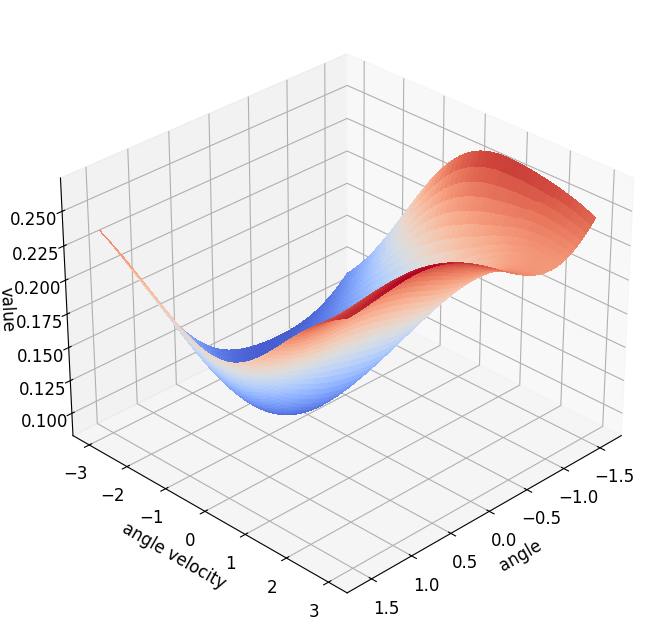

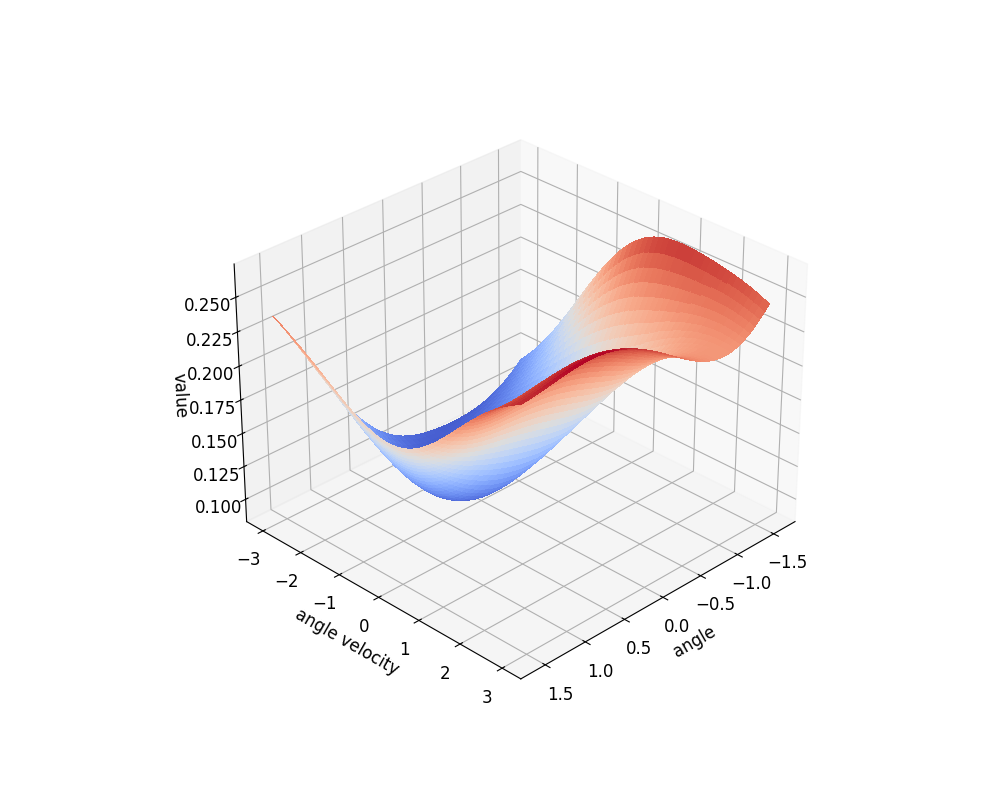

In [12]:
plot_value_function(valuefunc) # plot value function before learning

(2500, 3)


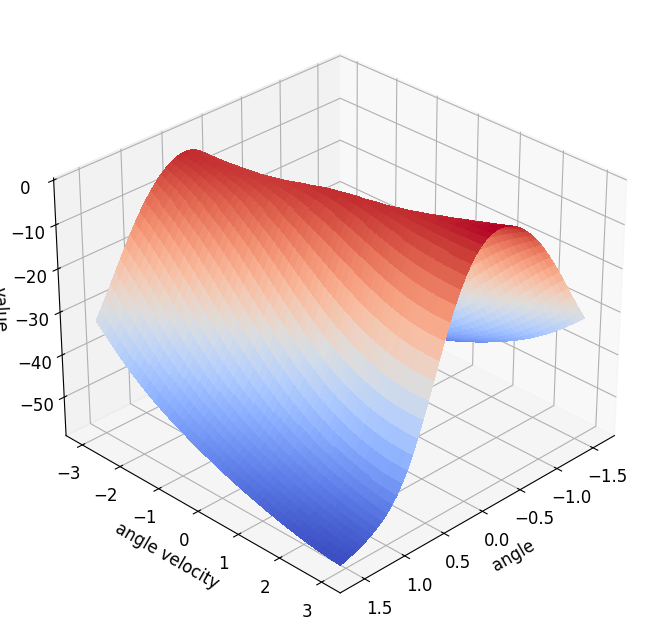

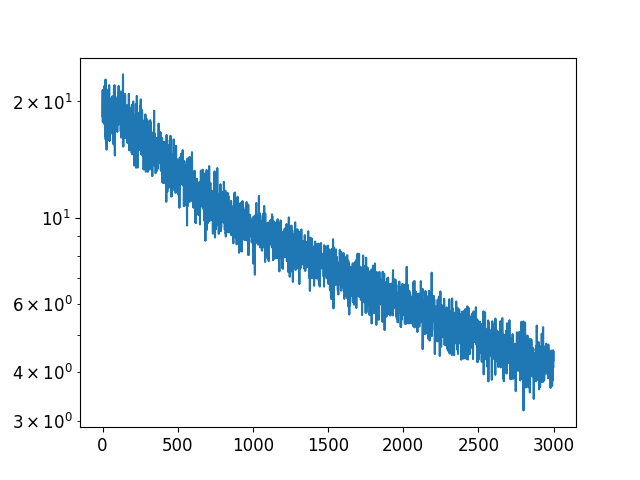

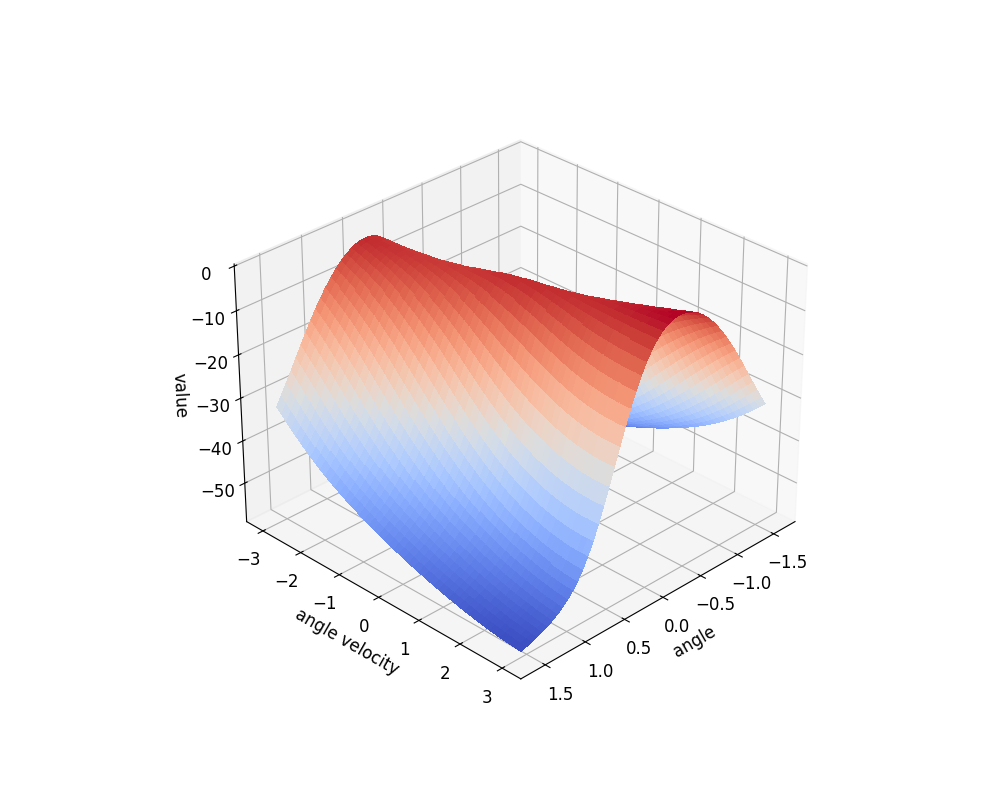

In [13]:
# gamma=0.95
valuefunc = ValueFunction(observation_dim=env.observation_space.shape[0])
fit_value(iter_fit=3000, gamma=0.95)
plot_value_function(valuefunc) # plot value function after learning

### Answer: Interpretation of fitted value function (gamma=0.95)

In the given policy, the amount of torque applied depends on the angular velocity of the pendulum. While applying torque is immediately costly, it is necessary to keep the pendulum at angle = 0. Hence, the value function is higher for higher magnitude of velocity, especially when angle is close to 0. For very low velocity and angle close to zero, it is the lowest because, here the policy specifies low torque which will take the pendulum to undesirable positions.

(2500, 3)


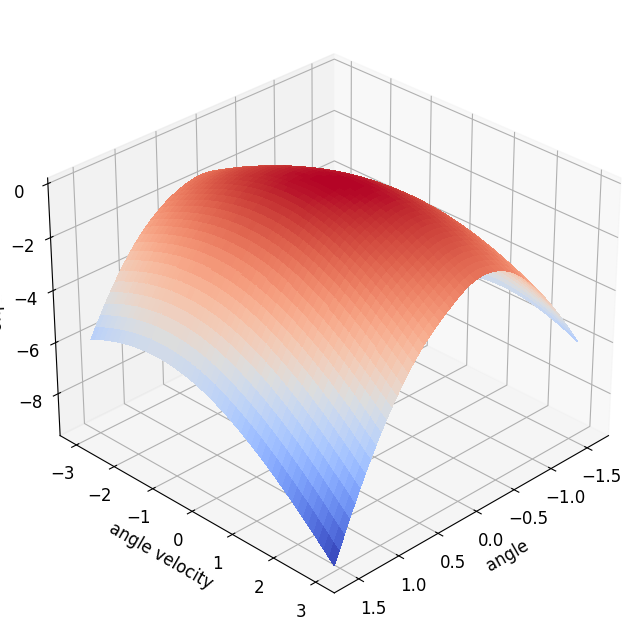

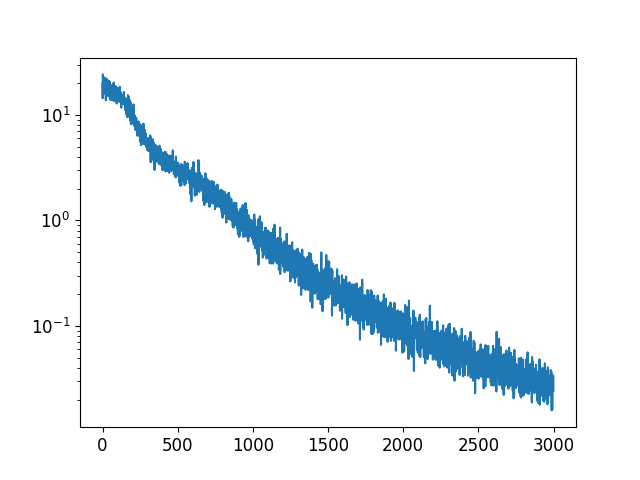

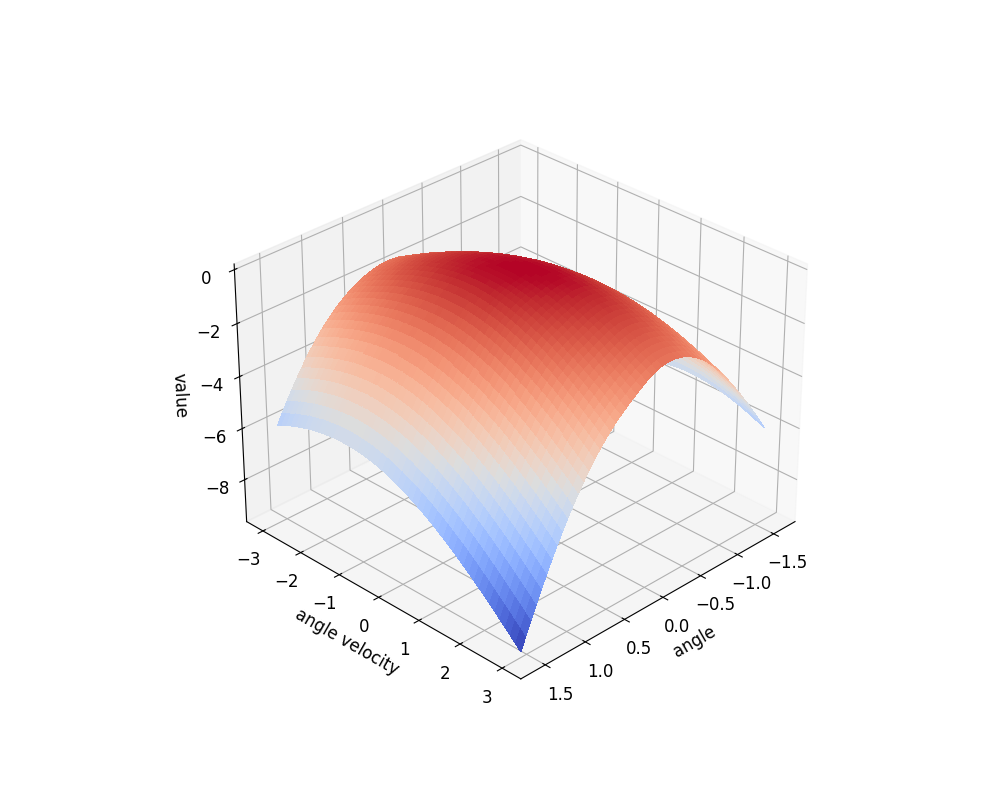

In [14]:
# gamma=0.5
valuefunc = ValueFunction(observation_dim=env.observation_space.shape[0])
fit_value(iter_fit=3000, gamma=0.5)
plot_value_function(valuefunc) # plot value function after learning

### Answer: Interpretation for value function (gamma = 0.5)

When discount factor is low, the future is discounted more and the value function reflects the immediate reward function more. Hence, in this case, value is higher when angle is closer to 0 (since immediate reward is highest here), although it is still higher for higher magnitude of angular velocities. The value function is lowest for very high velocities and angles far away from 0. This is because the immediate reward is the lowest here. 

Further, the value function converges more quickly here compared to discount factor = 0.95. 